In [61]:
import os, sys, glob
import math
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
mpl.rc('text', usetex=True)
sns.set_context("notebook", font_scale=1.75)
os.chdir("/Users/sarahchristensen/Documents/UIUC/Bioinformatics/Signatures/phySigs/results/mcpherson_ovary/")

# 1. Mcpherson Ovary

In [62]:
df = pd.read_csv("mcpherson.tsv", sep="\t")

In [63]:
df['norm_RSS'] = np.sqrt(df['RSS']) / (96*df['n'])

In [64]:
def identifyMinBIC(df, patient, tree_idx):
    k = int(df.iloc[df[(df['patient'] == patient) & (df['tree'] == tree_idx)]['BIC'].idxmin()]['k'])
    BIC = df[(df['patient'] == patient) & (df['tree'] == tree_idx)]['BIC'].min()
    RSS = df[(df['patient'] == patient) & (df['tree'] == tree_idx) & (df['k'] == k)]['RSS'].iloc[0]
    norm_RSS = df[(df['patient'] == patient) & (df['tree'] == tree_idx) & (df['k'] == k)]['norm_RSS'].iloc[0]
    return int(k), float(BIC), float(RSS), float(norm_RSS)

In [65]:
df['dRSS'] = 0.
df['rRSS'] = 1.
df['BIC_pref'] = False
df['max_k'] = False
for patient in set(df['patient']):
    for tree_idx in set(df[(df['patient'] == patient)]['tree']):
        k, BIC, RSS, norm_RSS = identifyMinBIC(df, patient, tree_idx)
        K = set(df[(df['patient'] == patient) & (df['tree'] == tree_idx)]['k'])
        max_k = max(K)
        for kk in K:
            idx = df[(df['patient'] == patient) & (df['tree'] == tree_idx) & (df['k'] == kk)]['BIC'].idxmin()
            RSS_kk = float(df.iloc[idx]['RSS'])
            norm_RSS_kk = float(df.iloc[idx]['norm_RSS'])
            df.at[idx, 'dRSS'] = RSS_kk - RSS
            df.at[idx, 'rRSS'] = RSS_kk / RSS
            df.at[idx, 'd_norm_RSS'] = norm_RSS_kk - norm_RSS
            df.at[idx, 'r_norm_RSS'] = norm_RSS_kk / norm_RSS
            df.at[idx, 'BIC_pref'] = kk == k
            df.at[idx, 'max_k'] = kk == max_k

In [66]:
df[df["BIC_pref"]].RSS.median()

22452.01

In [67]:
with open("mcpherson_sum.tsv", "w") as f:
    f.write("\t".join(["patient", "n", "tree", "k", 
                       "min_mut", "max_mut", "RSS", "method"]) + "\n")
    for patient in set(df['patient']):
        for tree_idx in set(df[(df['patient'] == patient)]['tree']):
            K = set(df[(df['patient'] == patient) & (df['tree'] == tree_idx)]['k'])
            n = int(df[(df['patient'] == patient) & (df['tree'] == tree_idx) & (df['k'] == 0)]['n'].iloc[0])
            max_k = max(K)
            f.write("\t".join(map(str, [patient, 
                                        n, 
                                        tree_idx, 
                                        0, 
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['k'] == 0)]['min_mut'].iloc[0]),
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['k'] == 0)]['max_mut'].iloc[0]),
                                        float(df[(df['patient'] == patient) & 
                                                  (df['tree'] == tree_idx) & 
                                                  (df['k'] == 0)]['RSS'].iloc[0]),
                                        "min-k"
                                       ])) + "\n")
            f.write("\t".join(map(str, [patient, 
                                        n, 
                                        tree_idx, 
                                        max_k, 
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['k'] == max_k)]['min_mut'].iloc[0]),
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['k'] == max_k)]['max_mut'].iloc[0]),
                                        float(df[(df['patient'] == patient) & 
                                                 (df['tree'] == tree_idx) & 
                                                 (df['k'] == max_k)]['RSS'].iloc[0]),
                                        "max-k"
                                       ])) + "\n")
            f.write("\t".join(map(str, [patient, 
                                        n, 
                                        tree_idx, 
                                        int(df[(df['patient'] == patient) & 
                                             (df['tree'] == tree_idx) & 
                                             (df['BIC_pref'])]['k'].iloc[0]),
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['BIC_pref'])]['min_mut'].iloc[0]),
                                        int(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['BIC_pref'])]['max_mut'].iloc[0]),
                                        float(df[(df['patient'] == patient) & 
                                               (df['tree'] == tree_idx) & 
                                               (df['BIC_pref'])]['RSS'].iloc[0]),
                                        "BIC-k"
                                       ])) + "\n")

In [68]:
df2 = pd.read_csv("mcpherson_sum.tsv", sep="\t")

In [69]:
df2['norm_RSS'] = np.sqrt(df2['RSS']) / (96*df2['n'])

In [70]:
df2['sqrt_RSS'] = np.sqrt(df2['RSS'])

In [71]:
df2['edges'] = df2['n'] - 1

In [72]:
##patients = set(df2[(df2["k"] > 0) & (df2["method"] == "BIC-k")].patient)

In [73]:
##df2[df2["patient"].isin(patients)]

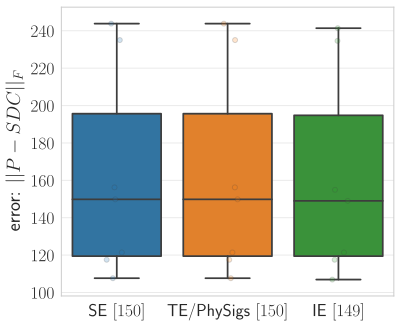

In [74]:
g = sns.boxplot(data=df2, x="method", y="sqrt_RSS", order=["min-k", "BIC-k", "max-k"], showfliers=False)
sns.stripplot(data=df2, x="method", y="sqrt_RSS", order=["min-k", "BIC-k", "max-k"], jitter=.1, alpha=.2, lw=1)
#g.set_ylim((15,85))
# g.set_yscale("log")
g.grid(which='both', axis='y', alpha=.4)
g.set_ylabel("error: $||P-SDC||_F$")
g.set_xlabel("")
g.set_xticklabels(["SE $[" + str(int(round(np.median(df2[(df2['method'] == "min-k")].sqrt_RSS), 0))) + "]$", 
                   "TE/PhySigs $[" + str(int(round(np.median(df2[(df2['method'] == "BIC-k")].sqrt_RSS), 0))) + "]$", 
                   "IE $[" + str(int(round(np.median(df2[(df2['method'] == "max-k")].sqrt_RSS), 0))) + "]$"])
plt.gcf().set_size_inches(6, 5)
plt.tight_layout()
plt.savefig("mcpherson_RSS.pdf")

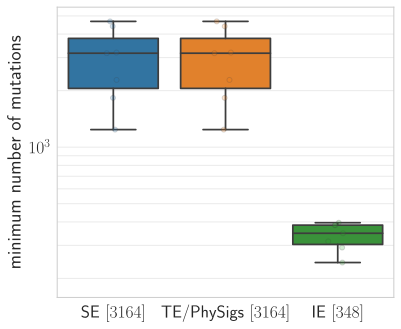

In [75]:
g = sns.boxplot(data=df2, x="method", y="min_mut", order=["min-k", "BIC-k", "max-k"], showfliers=False)
sns.stripplot(data=df2, x="method", y="min_mut", order=["min-k", "BIC-k", "max-k"], jitter=.1, alpha=.2, lw=1)
# g.set_ylim((0,1500))
g.set_yscale("log")
g.grid(which='both', axis='y', alpha=.4)
g.set_ylabel("minimum number of mutations")
g.set_xlabel("")
g.set_xticklabels(["SE $[" + str(int(np.median(df2[(df2['method'] == "min-k")].min_mut))) + "]$", 
                   "TE/PhySigs $[" + str(int(np.median(df2[(df2['method'] == "BIC-k")].min_mut))) + "]$", 
                   "IE $[" + str(int(np.median(df2[(df2['method'] == "max-k")].min_mut))) + "]$"])
plt.gcf().set_size_inches(6, 5) 
plt.tight_layout()
plt.savefig("mcpherson_min_mut.pdf")

In [76]:
len(df2[(df2["method"] == "BIC-k") & (df2["k"]==2)])

0

In [77]:
set(df2.n)

{3, 5, 6, 7, 8, 9}

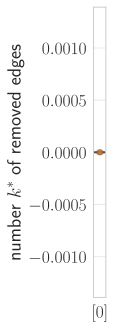

In [78]:
g = sns.boxplot(data=df2[df2['n']>0], x="method", y="k", order=["BIC-k"], showfliers=False, 
                color=sns.color_palette()[1])
sns.stripplot(data=df2[df2['n']>0], x="method", y="k", order=["BIC-k"], jitter=.1, 
              alpha=.2, lw=1, color=sns.color_palette()[1])
# g.set_ylim((-0.5,17))
# g.set_yscale("log")
g.grid(which='both', axis='y', alpha=.4)
g.set_ylabel("number $k^*$ of removed edges")
g.set_xlabel("")
g.set_xticklabels([])
g.set_xticklabels(["$[" + str(int(np.median(df2[df2['method'] == "BIC-k"].k))) + "]$"])
plt.gcf().set_size_inches(2, 5) 
plt.tight_layout()
plt.savefig("mcpherson_kstar.pdf")

In [79]:
df2_count = df2[(df2["method"]=="BIC-k")].groupby(["k"]).count()["patient"].to_frame().rename(columns={"patient":"count"}).reset_index()

In [80]:
int(df2_count[df2_count["k"]==0]["count"])

7

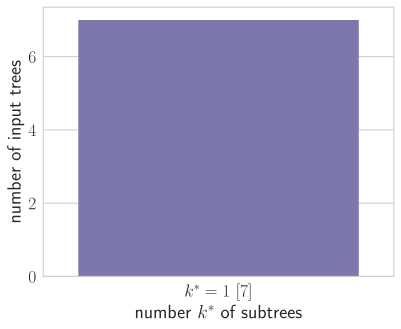

In [81]:
g = sns.barplot(data=df2_count, x="k", y="count", palette = sns.color_palette("Dark2")[2:])
g.set_ylabel("number of input trees")
g.set_xlabel("number $k^*$ of subtrees")
g.set_xticklabels(["$k^*=1$ $[" + str(int(df2_count[df2_count["k"]==0]["count"])) + "]$"])
plt.gcf().set_size_inches(6, 5)
plt.tight_layout()
plt.savefig("mcpherson_kstar.pdf")

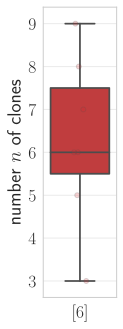

In [82]:
g = sns.boxplot(data=df2, x="method", y="n", order=["BIC-k"], showfliers=False, 
                color=sns.color_palette()[3])
sns.stripplot(data=df2, x="method", y="n", order=["BIC-k"], jitter=.1, 
              alpha=.2, lw=1, color=sns.color_palette()[3])
g.grid(which='both', axis='y', alpha=.4)
#g.set_ylim((0,18))
g.set_ylabel("number $n$ of clones")
g.set_xlabel("")
g.set_xticklabels(["$[" + str(int(np.median(df2[(df2['method'] == "BIC-k")].n))) + "]$"])
plt.gcf().set_size_inches(2.15, 5)
plt.tight_layout()
plt.savefig("mcpherson_nodes.pdf")

In [83]:
len(df2[df2['method'] == 'BIC-k'])

7

In [84]:
len(set(df2.patient))

7

In [85]:
max(df2.n)

9